In [26]:
import antiCPy
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib
warnings.filterwarnings("ignore")
from scipy.stats import mode
import seaborn as sns
matplotlib.rc_file_defaults()

In [27]:
from antiCPy.trend_extrapolation.cp_segment_fit import CPSegmentFit

In [28]:
# get a seed
np.random.seed(1234)


In [29]:
def Reduced(x):
    # Reduces the range of the x axis to suit the calculated probability, 
    # i.e. drops first and last values
    X = x[1:]
    return(X[:-1])

In [30]:
# all in one function
def CP_Distribution(x,Y,n):
    y = np.sort(Y)
    
    
    CPFit = CPSegmentFit(x_data = x,
                         y_data = y,
                         number_expected_changepoints = n,
                         num_MC_cp_samples = 1000000,
                         z_array_size = 100                         
                        )
    
    CPFit.initialize_MC_cp_configurations(print_sum_control = True)
    CPFit.initialize_A_matrices()
    try:
        CPFit.Q_matrix_and_inverse_Q()
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            CPFit.initialize_MC_cp_configurations()
            CPFit.initialize_A_matrices()
            
    
    CPFit.calculate_f0()
    CPFit.calculate_residue()
    CPFit.calculate_marginal_likelihood()
    CPFit.calculate_marginal_cp_pdf()
    CPFit.calculate_prob_cp()
    
    return(CPFit.prob_cp)

## More selective Output

Make sure that the output of the function is 
1) The number of relevant terms
2) The index of the relevant terms

In [31]:
# all in one function: both number of relevant terms and index of relevant terms as output
# input: "time" x, Time Series Y that will be sorted ascendingly, n number of Change Points
def CP_Distr(x,Y,n):
    y = np.sort(Y)
    
    
    CPFit = CPSegmentFit(x_data = x,
             y_data = y,
             number_expected_changepoints = n,
             num_MC_cp_samples = 1000000,
                   z_array_size = 100)
    
    CPFit.initialize_MC_cp_configurations(print_sum_control = True)
    CPFit.initialize_A_matrices()
    try:
        CPFit.Q_matrix_and_inverse_Q()
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            CPFit.initialize_MC_cp_configurations()
            CPFit.initialize_A_matrices()
            
    
    CPFit.calculate_f0()
    CPFit.calculate_residue()
    CPFit.calculate_marginal_likelihood()
    CPFit.calculate_marginal_cp_pdf()
    CPFit.calculate_prob_cp()
    
    Probabilities = CPFit.prob_cp
    
    # where is the maximum for the CP Distribution?
    PositionMaximum = np.argmax(Probabilities)
    # note that Probabilities "lost" the first and last index of y
    
    CP_Value = y[PositionMaximum+1] # +1 because y[0] has been disregarded
    
    RelevantIndex = (Y> CP_Value)
    
    return([sum(Y>CP_Value), RelevantIndex])

## Now with the full XAI data set

In [32]:
XAI = np.load("XAI_Finance.npy")
XAI_x =  np.arange(XAI.shape[1])
Names = np.load("Names.npy")
CorrMatrices = np.load("CorrMatricesTriangular.npy")
LabelNaiveOrdered = np.load("LabelNaiveOrdered.npy")
XAI.shape, Names

((5251, 45),
 array(['E', 'M', 'F', 'CS', 'CD', 'U', 'T', 'IT', 'I', 'HC'], dtype='<U2'))

In [33]:
Names = list(Names)

# E: Energy, CD: Constumer Discretionary, F: Financials, I: Industrials, U: Utilities, CS: Constumer Staples,
# RE: Real Estate, Com: Communication Services, M: Materials, IT: Information Technology, HC: Health Care

In [34]:
def plot_matrix(m, title='Correlation Matrix', cmap=plt.cm.Blues, labels= None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(m)
    plt.title(title,y=1.08)
    fig.colorbar(cax)
    
    
    xaxis = np.arange(len(labels))
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    #ax.set_xticklabels([''] + labels)
    #ax.set_yticklabels([''] + labels)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('Sectors')
    plt.ylabel('Sectors')
    plt.show()
   

In [35]:
# Transform back to original sectors

def ReverseDiag(Array, ZERO = False, MEAN = False):
    N = np.sqrt(2*len(Array)+0.25)+0.5
    N = int(N)
    Original = np.ones(int(N**2.)).reshape(1,-1)
    
    if ZERO:
        Original = np.zeros(int(N**2.)).reshape(1,-1)

    if MEAN:
        Original = Original * np.mean(Array) # mean interpolation for the diagonal

    index = np.triu(np.ones((N,N)),1)
    index = index.reshape(1,-1)
    index = index.astype(bool)
    
    Original[index] = Array # upper triangle
    Original = Original.reshape((N,N))
    Original = Original.T  # guarantee symmetry
    Original=Original.reshape(1,-1)
    Original[index] = Array
    Original=Original.reshape((N,N))

    return(Original)

In [36]:
def PrintNames(Mat, Names):
    Out = list()
    for i in range(Mat.shape[0]):
        for j in range(i+1, Mat.shape[1]):
            if Mat[i,j]==1:
                Out.append(Names[i]+"/"+Names[j])
    return(Out)

## Focus on the Modal Values instead of Means

In [37]:


def RankModes(Modals):
    # Takes tuple Modes with Modals[0] = list of features which appear as modal values at least once
    #                        Modals[1] = list of how often the features are modal values

    Moderanks = np.empty((len(Modals[0]),2)) # 2D array for feature and number of being modal value
    Moderanks[:,0], Moderanks[:,1] = Modals[0], Modals[1]
    Moderanks = Moderanks.astype("int")

    # fill up the features which are never a modal value for any instance
    Missings = set(range(CorrMatrices.shape[1])) - set(Moderanks[:,0])
    Missingranks = np.zeros((len(Missings),2)).astype("int") # are modal values for 0 instances
    Missingranks[:,0] = np.array(list(Missings))

    # and combine both arrays
    Moderanks = np.concatenate((Moderanks, Missingranks))
    Moderanks = Moderanks[Moderanks[:, 0].argsort()]

    return(Moderanks)

In [38]:
# FIRST: One loop which evaluated the CP_Distr-function because this produces a lot of text as output which can get distracting otherwise. The actually interesting loop appears later in the code

CP_Modal_list = list()


for j in range(1+int(max(LabelNaiveOrdered))):
    Modes = np.unique(np.argmax(XAI[LabelNaiveOrdered==j,:],1),
             return_counts=True)
    RM = RankModes(Modes)
    CP_Modal = CP_Distr(np.arange(XAI.shape[1]),
                  RM[:,1],
                  1)
    CP_Modal_list.append(CP_Modal)
    print(j, CP_Modal[0], CP_Modal[1] )

number of MC cp samples before exact correction:  1000000
number of MC cp samples:  43
Less configurations than MC sample proposal. Compute exact sum!
Possible configs:  [[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]
 [34]
 [35]
 [36]
 [37]
 [38]
 [39]
 [40]
 [41]
 [42]
 [43]]
Possible configs shape:  (43, 1)
composition_dummy:  [[ 0.  1. 44.]
 [ 0.  2. 44.]
 [ 0.  3. 44.]
 [ 0.  4. 44.]
 [ 0.  5. 44.]
 [ 0.  6. 44.]
 [ 0.  7. 44.]
 [ 0.  8. 44.]
 [ 0.  9. 44.]
 [ 0. 10. 44.]
 [ 0. 11. 44.]
 [ 0. 12. 44.]
 [ 0. 13. 44.]
 [ 0. 14. 44.]
 [ 0. 15. 44.]
 [ 0. 16. 44.]
 [ 0. 17. 44.]
 [ 0. 18. 44.]
 [ 0. 19. 44.]
 [ 0. 20. 44.]
 [ 0. 21. 44.]
 [ 0. 22. 44.]
 [ 0. 23. 44.]
 [ 0. 24. 44.]
 [ 0. 25. 44.]
 [ 0. 26. 44.]
 [ 0. 27. 44.]
 [ 0. 28. 44.]
 [ 0. 29. 44.]
 [ 0. 30. 44.]
 [ 0. 31. 44.]
 [ 0. 32. 44.]
 [ 0. 33. 44.]
 [ 0. 34. 44.]
 [ 0. 35

In [39]:
CP_Modal_list[5][1]

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False,  True, False])

27


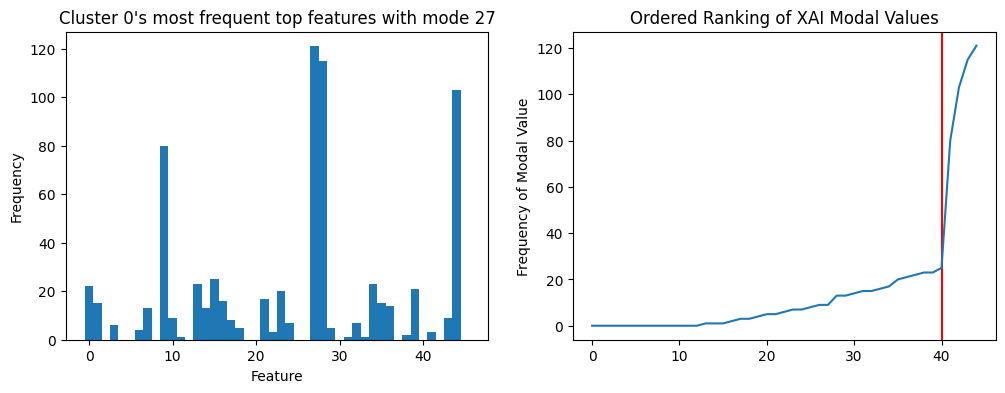

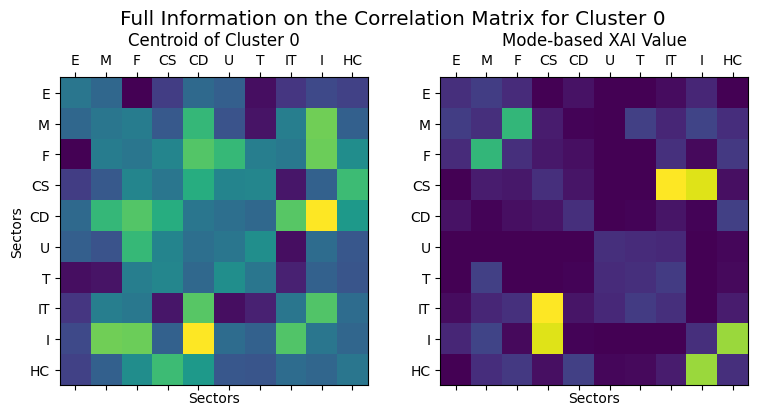

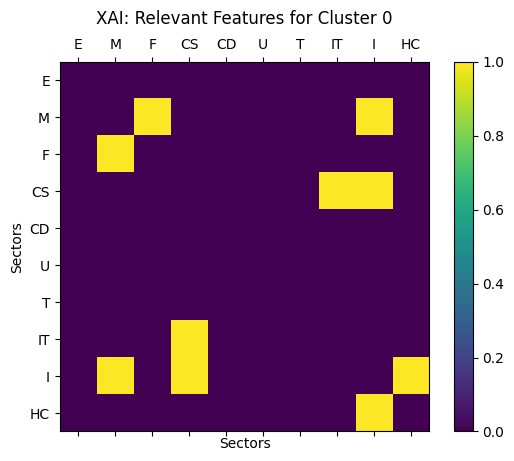

Relevant Correlations: ['M/F', 'M/I', 'CS/IT', 'CS/I', 'I/HC']
Cluster 0 is most XAI-influenced by correlation 27


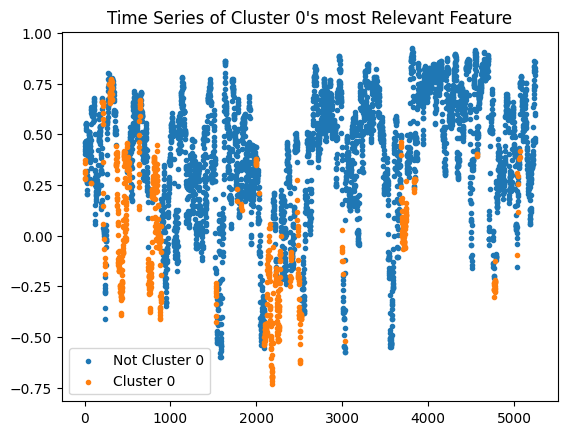

#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#
8


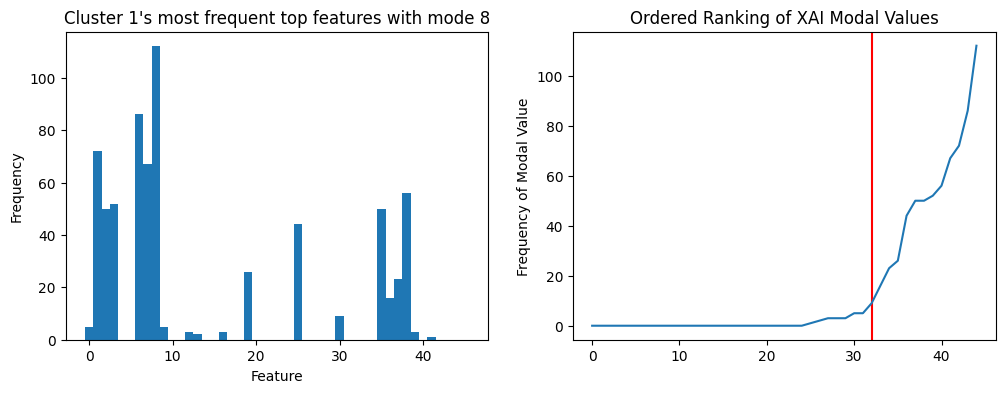

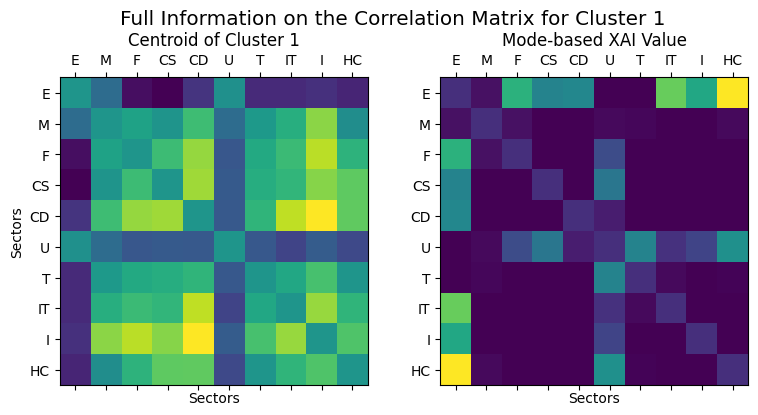

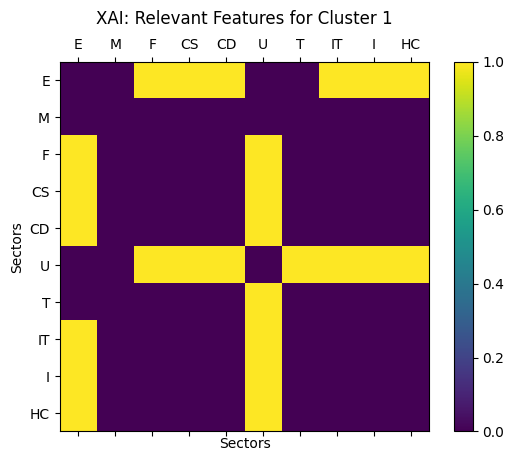

Relevant Correlations: ['E/F', 'E/CS', 'E/CD', 'E/IT', 'E/I', 'E/HC', 'F/U', 'CS/U', 'CD/U', 'U/T', 'U/IT', 'U/I', 'U/HC']
Cluster 1 is most XAI-influenced by correlation 8


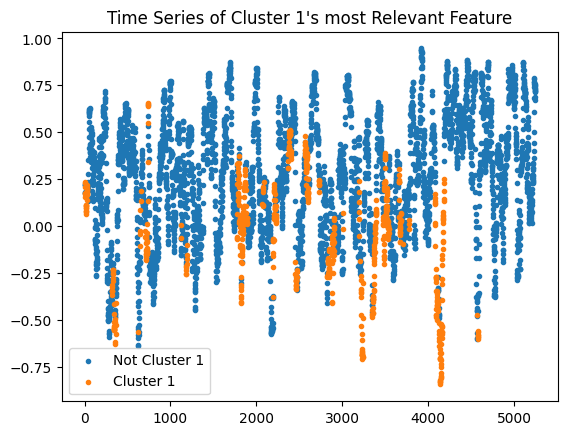

#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#
36


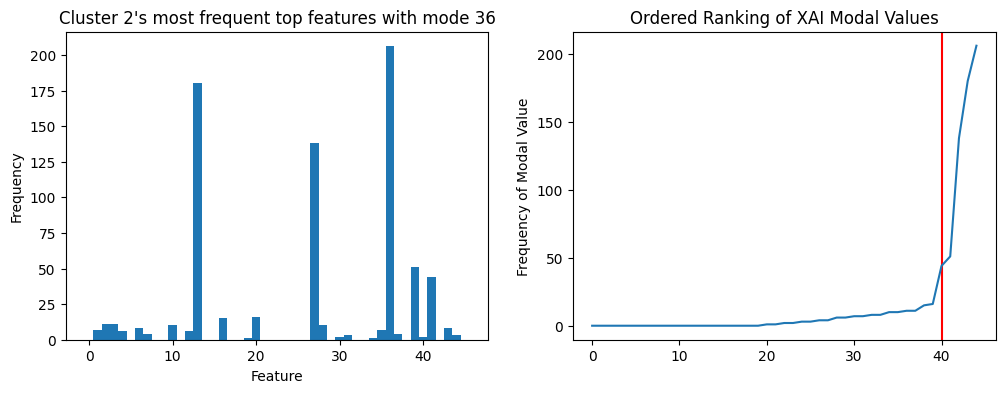

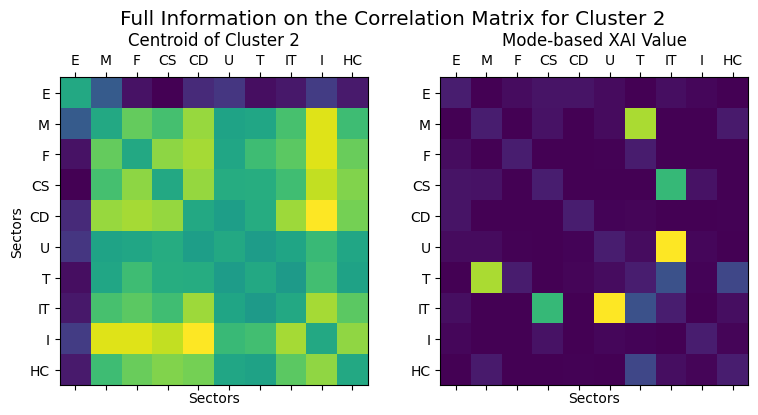

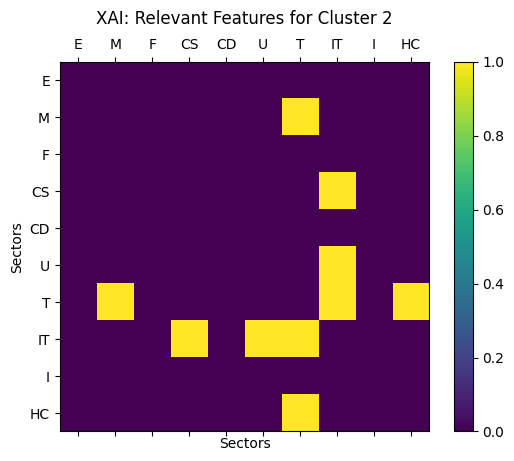

Relevant Correlations: ['M/T', 'CS/IT', 'U/IT', 'T/IT', 'T/HC']
Cluster 2 is most XAI-influenced by correlation 36


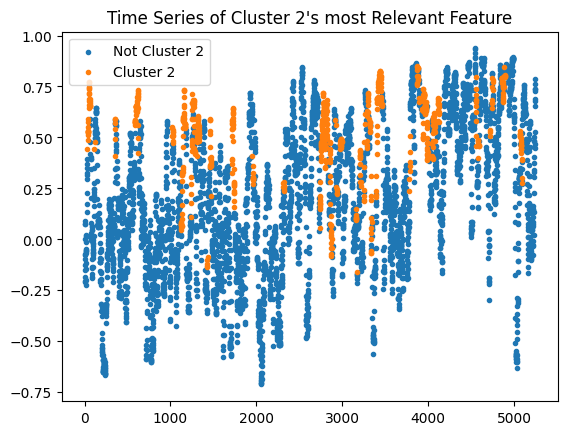

#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#
35


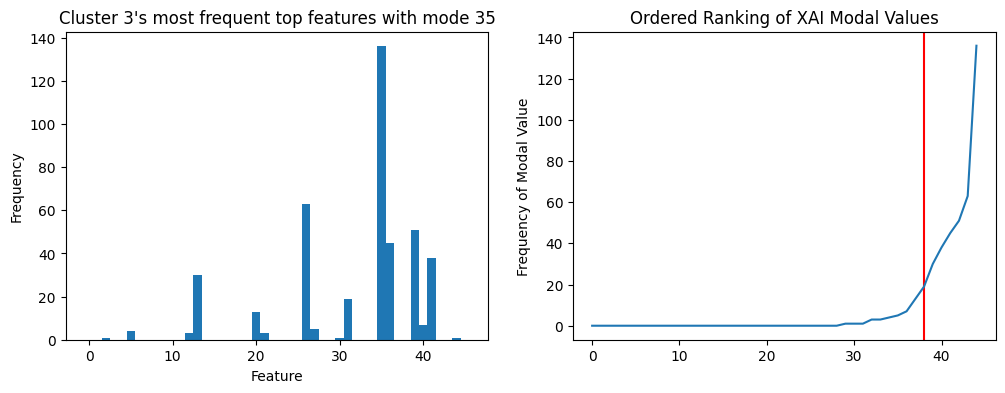

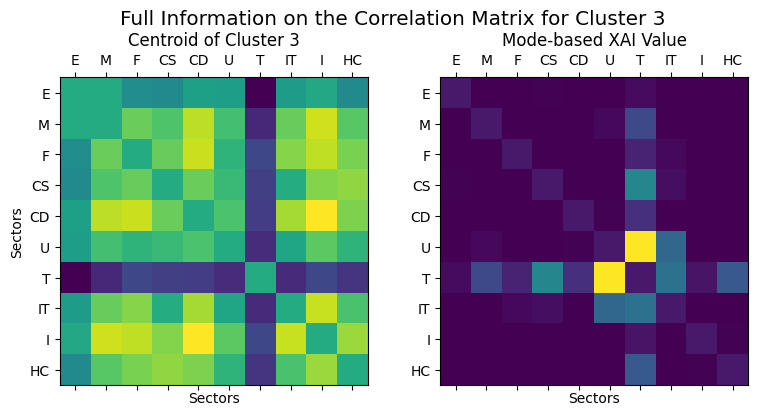

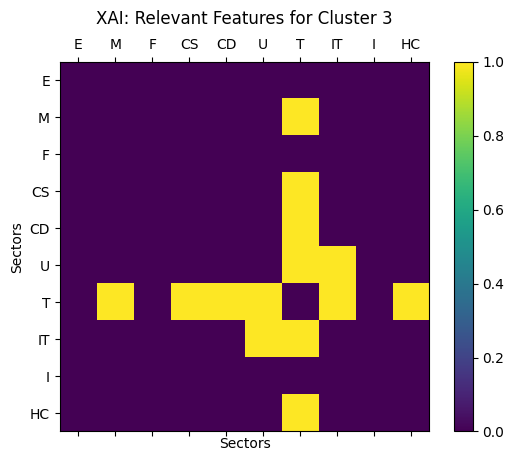

Relevant Correlations: ['M/T', 'CS/T', 'CD/T', 'U/T', 'U/IT', 'T/IT', 'T/HC']
Cluster 3 is most XAI-influenced by correlation 35


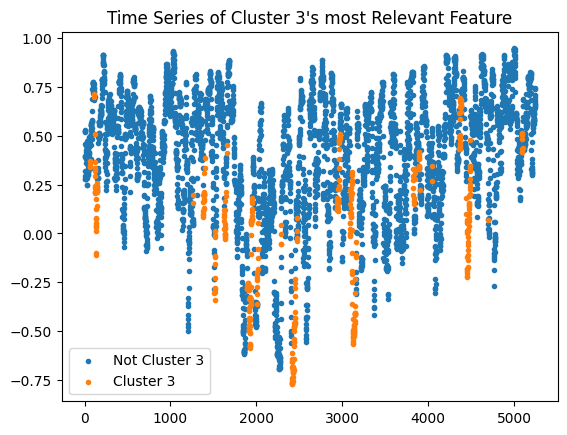

#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#
12


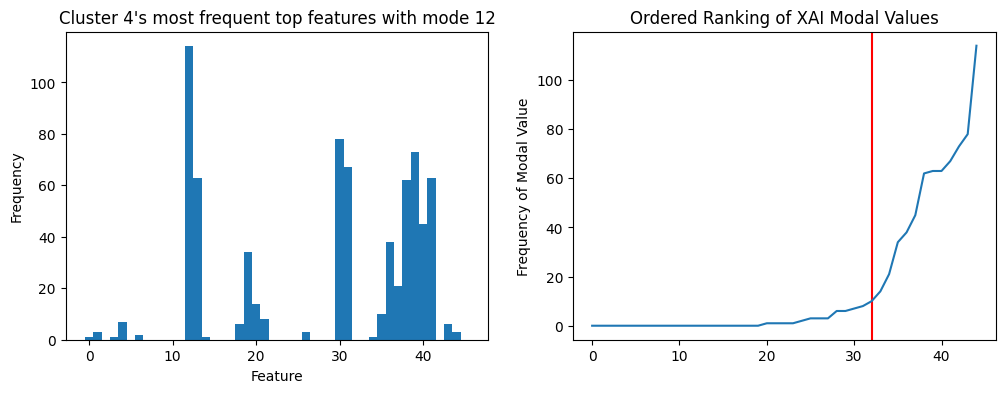

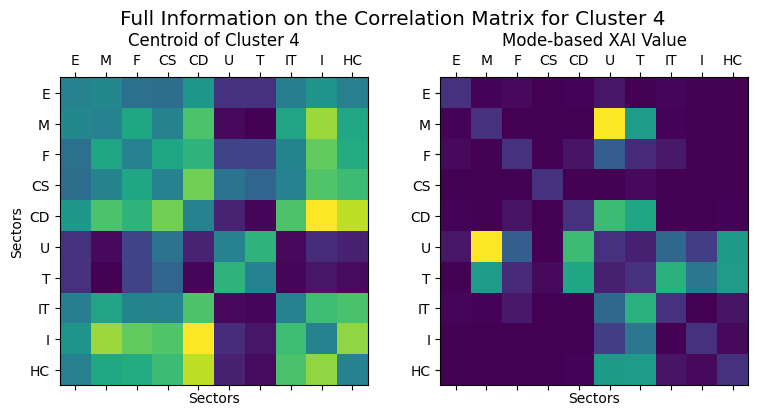

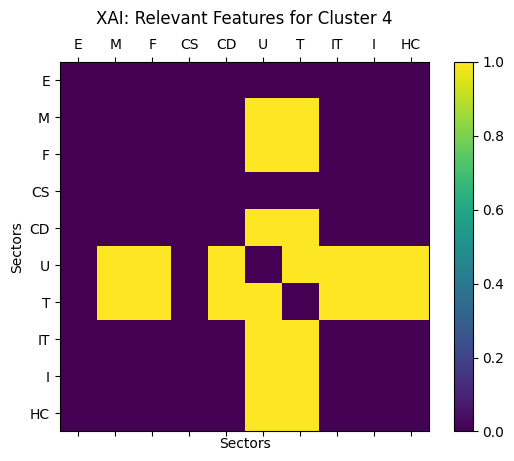

Relevant Correlations: ['M/U', 'M/T', 'F/U', 'F/T', 'CD/U', 'CD/T', 'U/T', 'U/IT', 'U/I', 'U/HC', 'T/IT', 'T/I', 'T/HC']
Cluster 4 is most XAI-influenced by correlation 12


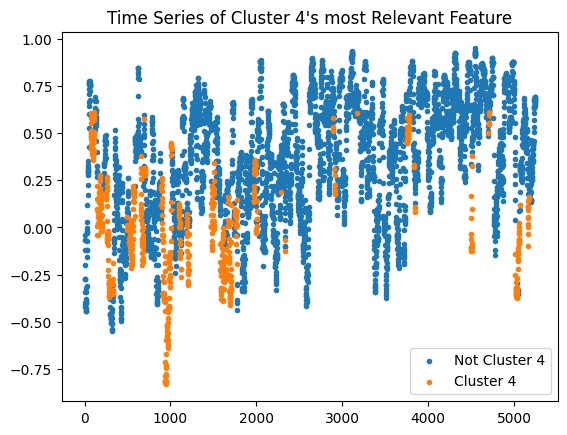

#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#
21


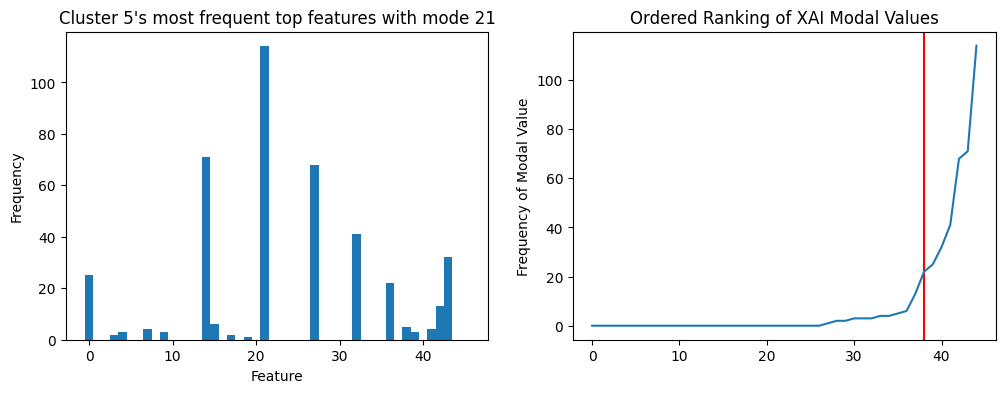

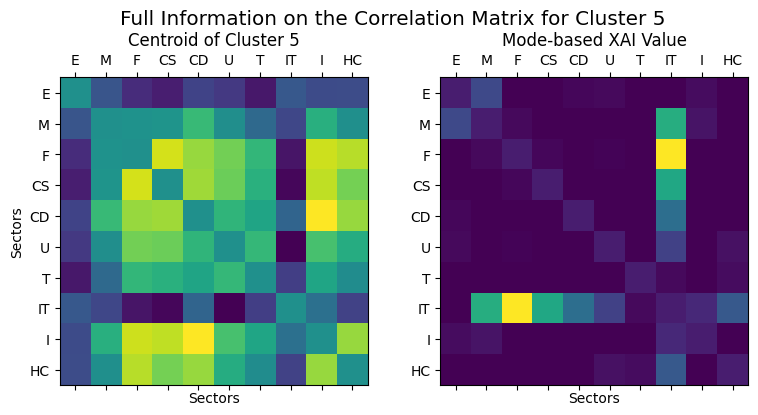

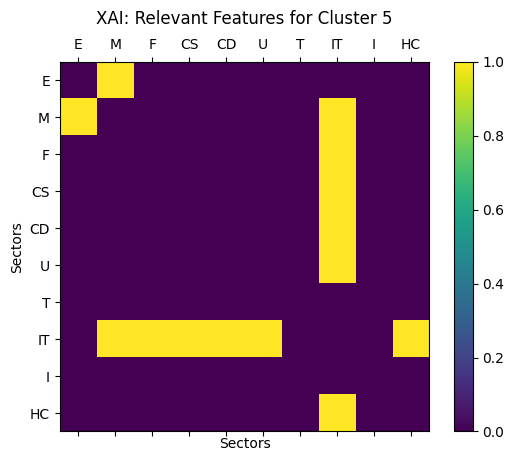

Relevant Correlations: ['E/M', 'M/IT', 'F/IT', 'CS/IT', 'CD/IT', 'U/IT', 'IT/HC']
Cluster 5 is most XAI-influenced by correlation 21


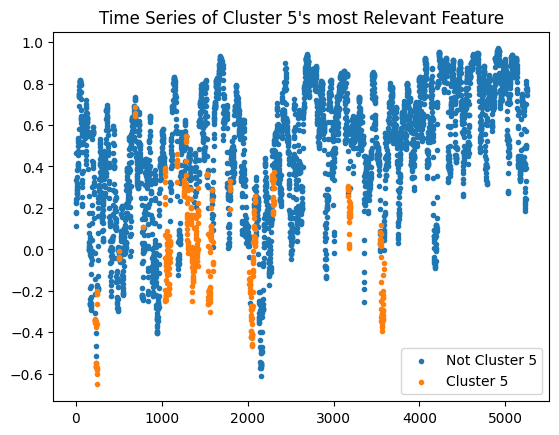

#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#
0


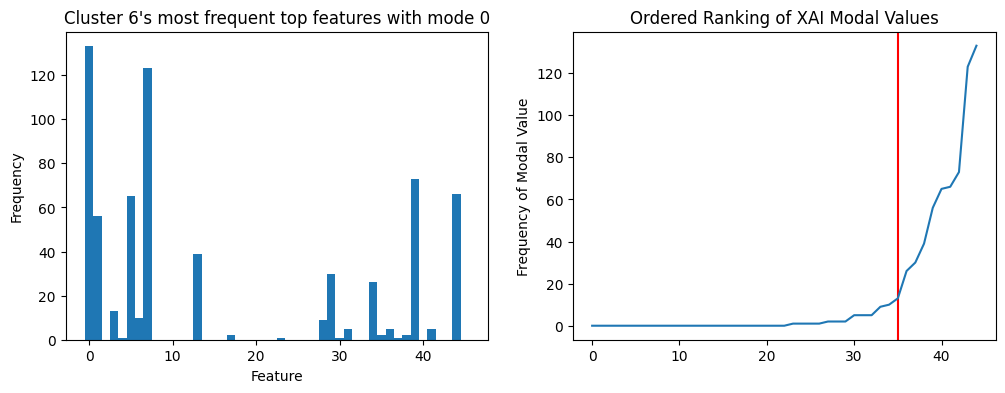

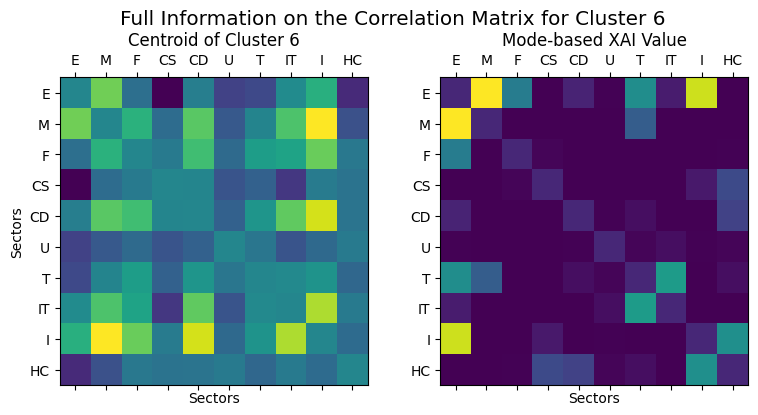

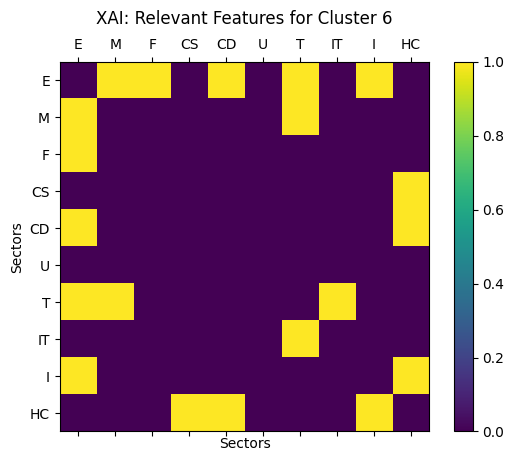

Relevant Correlations: ['E/M', 'E/F', 'E/CD', 'E/T', 'E/I', 'M/T', 'CS/HC', 'CD/HC', 'T/IT', 'I/HC']
Cluster 6 is most XAI-influenced by correlation 0


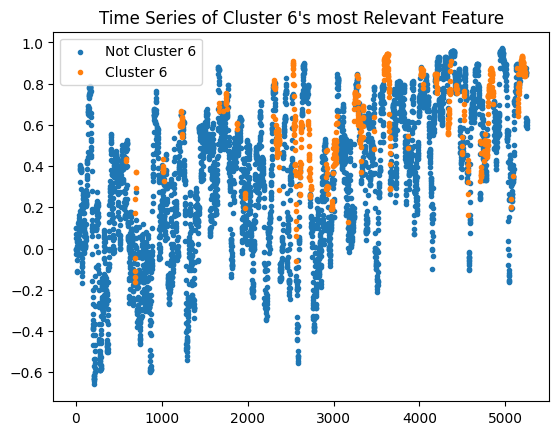

#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#
1


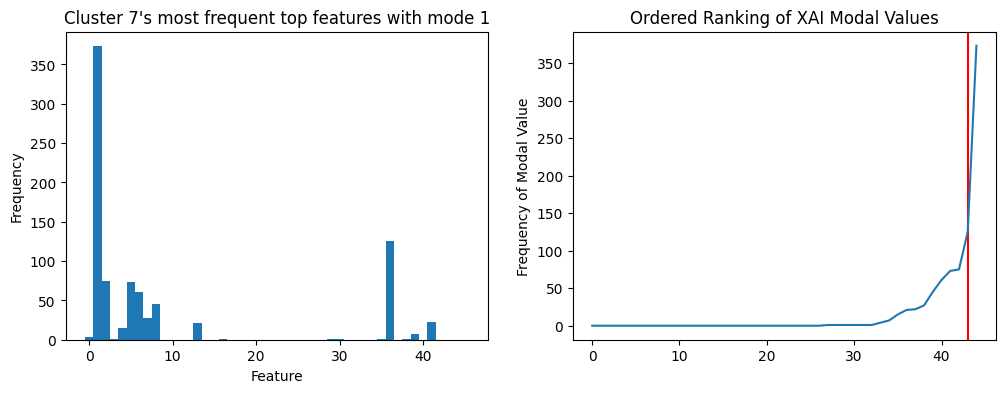

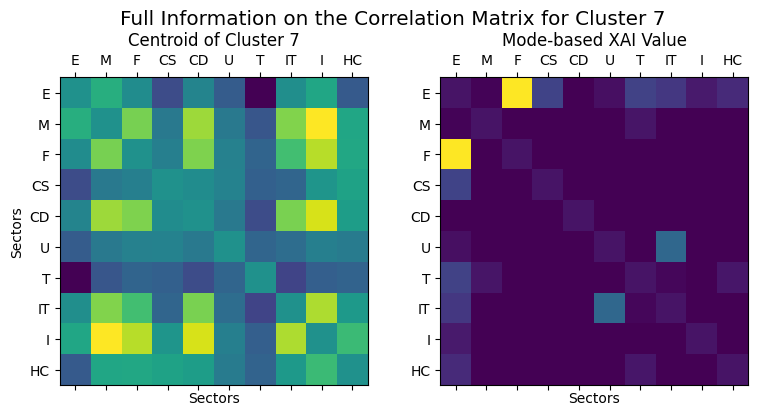

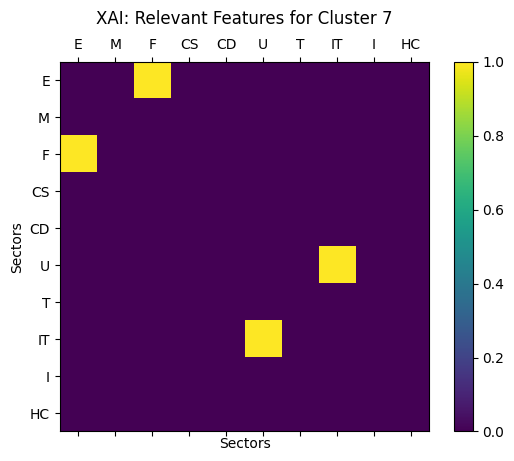

Relevant Correlations: ['E/F', 'U/IT']
Cluster 7 is most XAI-influenced by correlation 1


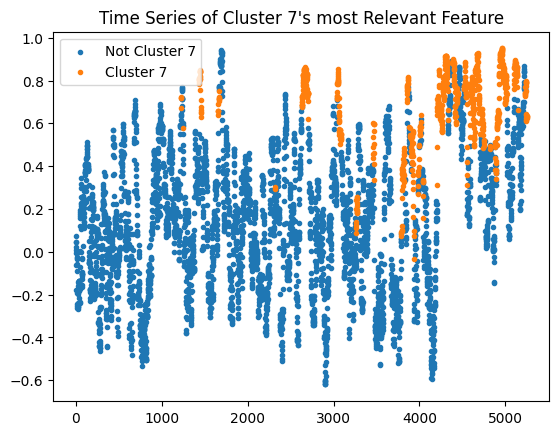

#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#


In [40]:
XAI_modes = np.empty((int(max(LabelNaiveOrdered)+1),2))




for j in range(1+int(max(LabelNaiveOrdered))):
    XAI_j = XAI[LabelNaiveOrdered==j,:]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)

    ax1.hist(np.argmax(XAI_j,1), bins = np.arange(-0.5,
                                            XAI.shape[1]+1.5,
                                            1))
    print(mode(np.argmax(XAI_j,1))[0][0])
    XAI_modes[j,0] = j
    XAI_modes[j,1] = int(mode(np.argmax(XAI_j,1))[0][0])
    ax1.set_title("Cluster "+str(j)+"'s most frequent top features with mode "
              + str(mode(np.argmax(XAI_j,1))[0][0]))
    ax1.set_xlabel("Feature")
    ax1.set_ylabel("Frequency")

    Modes = np.unique(np.argmax(XAI[LabelNaiveOrdered==j,:],1),
             return_counts=True)
    RM = RankModes(Modes)

    ax2.set_title("Ordered Ranking of XAI Modal Values")
    ax2.set_ylabel("Frequency of Modal Value")
    ax2.axvline(len(RM[:,1])-CP_Modal_list[j][0],c="red")
    ax2.plot(np.sort(RM[:,1]))
    plt.show()



    ############


    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Full Information on the Correlation Matrix for Cluster '+str(j),
                 fontsize = 'x-large',
                 y=1.05)
    fig.set_size_inches(9, 4)
    xaxis = np.arange(len(Names))

    ax1.matshow(ReverseDiag(CorrMatrices[LabelNaiveOrdered==j,:].mean(0),
                            MEAN = True))
    ax1.set_title("Centroid of Cluster " + str(j))
    ax1.set_xticks(xaxis)
    ax1.set_yticks(xaxis)
    ax1.set_xticklabels(Names)
    ax1.set_yticklabels(Names)

    ax2.matshow(ReverseDiag(RM[:,1], MEAN=True))
    ax2.set_title("Mode-based XAI Value")
    ax2.set_xticks(xaxis)
    ax2.set_yticks(xaxis)
    ax2.set_xticklabels(Names)
    ax2.set_yticklabels(Names)

    ax1.set_xlabel('Sectors')
    ax1.set_ylabel('Sectors')
    ax2.set_xlabel('Sectors')

    #plt.savefig("Centroid_vs_XAI_cluster"+ str(j)+".pdf", dpi=350, bbox_inches='tight')
    plt.show()


    relIndex = np.zeros(45)
    relIndex[CP_Modal_list[j][1]] = 1.
    RelMat = ReverseDiag(relIndex,
                       ZERO = True)

    plot_matrix(RelMat,
            title = "XAI: Relevant Features for Cluster "+str(j),
           labels = Names)
    print("Relevant Correlations:",PrintNames(RelMat, Names))


    print("Cluster", j, "is most XAI-influenced by correlation",np.argmax(RM[:,1]))
    RelevantFeature = CorrMatrices[:,np.argmax(RM[:,1])]

    Time = np.arange(CorrMatrices.shape[0])

    plt.scatter(Time[LabelNaiveOrdered!=j],
            RelevantFeature[LabelNaiveOrdered!=j],
            marker =".", label="Not Cluster "+str(j))
    plt.scatter(Time[LabelNaiveOrdered==j],
            RelevantFeature[LabelNaiveOrdered==j],
            marker =".", label="Cluster "+str(j))
    plt.title("Time Series of Cluster "+str(j)+"'s most Relevant Feature")
    plt.legend()
    plt.show()

    print("#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#")

In [41]:
XAI_modes = XAI_modes.astype("int")
print(XAI_modes)
np.save("XAI_modes", XAI_modes)

[[ 0 27]
 [ 1  8]
 [ 2 36]
 [ 3 35]
 [ 4 12]
 [ 5 21]
 [ 6  0]
 [ 7  1]]


Makes sense that some features are used for more than one cluster because (my hypothesis:) their values help to differentiate exactly between those clusters

## Try the Median instead

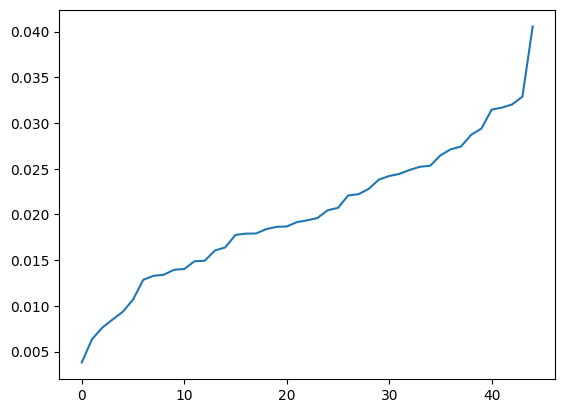

number of MC cp samples before exact correction:  1000000
number of MC cp samples:  43
Less configurations than MC sample proposal. Compute exact sum!
Possible configs:  [[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]
 [34]
 [35]
 [36]
 [37]
 [38]
 [39]
 [40]
 [41]
 [42]
 [43]]
Possible configs shape:  (43, 1)
composition_dummy:  [[ 0.  1. 44.]
 [ 0.  2. 44.]
 [ 0.  3. 44.]
 [ 0.  4. 44.]
 [ 0.  5. 44.]
 [ 0.  6. 44.]
 [ 0.  7. 44.]
 [ 0.  8. 44.]
 [ 0.  9. 44.]
 [ 0. 10. 44.]
 [ 0. 11. 44.]
 [ 0. 12. 44.]
 [ 0. 13. 44.]
 [ 0. 14. 44.]
 [ 0. 15. 44.]
 [ 0. 16. 44.]
 [ 0. 17. 44.]
 [ 0. 18. 44.]
 [ 0. 19. 44.]
 [ 0. 20. 44.]
 [ 0. 21. 44.]
 [ 0. 22. 44.]
 [ 0. 23. 44.]
 [ 0. 24. 44.]
 [ 0. 25. 44.]
 [ 0. 26. 44.]
 [ 0. 27. 44.]
 [ 0. 28. 44.]
 [ 0. 29. 44.]
 [ 0. 30. 44.]
 [ 0. 31. 44.]
 [ 0. 32. 44.]
 [ 0. 33. 44.]
 [ 0. 34. 44.]
 [ 0. 35

In [42]:
#XAI_median =np.median(abs(XAI),0)
XAI_median =np.median(XAI,0)

plt.plot(np.sort(XAI_median))
plt.show()
CP_median = CP_Distr(np.arange(XAI.shape[1]),
                  XAI_median,
                  1)

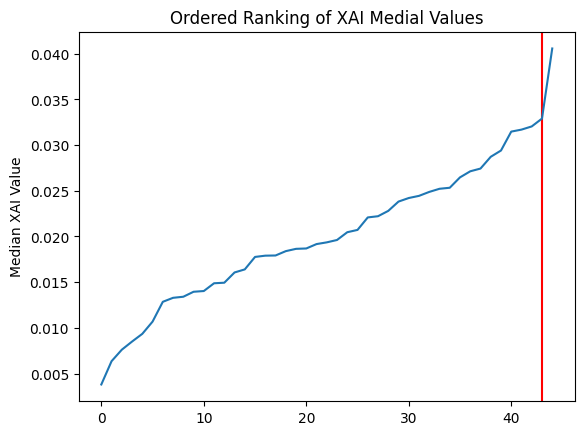

[2,
 array([False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False])]

In [43]:
plt.title("Ordered Ranking of XAI Medial Values")
plt.ylabel("Median XAI Value")
plt.axvline(len(XAI_median)-CP_median[0],c="red")
plt.plot(np.sort(XAI_median))
plt.show()
CP_median

In [44]:
Comparison = len(list(set(XAI_modes[:,1])))
print( np.sort(XAI_median)[-Comparison].round(4), np.sort(XAI_median).round(4))

0.0274 [0.0038 0.0063 0.0076 0.0085 0.0093 0.0107 0.0128 0.0133 0.0134 0.0139
 0.014  0.0149 0.0149 0.0161 0.0164 0.0178 0.0179 0.0179 0.0184 0.0186
 0.0187 0.0192 0.0194 0.0196 0.0205 0.0207 0.0221 0.0222 0.0228 0.0238
 0.0242 0.0244 0.0249 0.0252 0.0253 0.0265 0.0271 0.0274 0.0287 0.0294
 0.0315 0.0317 0.032  0.0329 0.0406]


In [45]:
MedianLogical = (XAI_median >=  np.sort(XAI_median)[-Comparison])
print(sum(MedianLogical) == Comparison)
np.save("MedianLogical", MedianLogical)

True


In [46]:
# FIRST: One loop which evaluated the CP_Distr-function because this produces a lot of text as output which can get distracting otherwise. The actually interesting loop appears later in the code

CP_Median_list = list()


for j in range(1+int(max(LabelNaiveOrdered))):
    XAI_j = XAI[LabelNaiveOrdered==j,:]
    CP_Median = CP_Distr(np.arange(XAI.shape[1]),
                  np.median(XAI_j,0),
                  1)
    CP_Median_list.append(CP_Median)
    print(j, CP_Median[0], CP_Median[1] )

number of MC cp samples before exact correction:  1000000
number of MC cp samples:  43
Less configurations than MC sample proposal. Compute exact sum!
Possible configs:  [[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]
 [34]
 [35]
 [36]
 [37]
 [38]
 [39]
 [40]
 [41]
 [42]
 [43]]
Possible configs shape:  (43, 1)
composition_dummy:  [[ 0.  1. 44.]
 [ 0.  2. 44.]
 [ 0.  3. 44.]
 [ 0.  4. 44.]
 [ 0.  5. 44.]
 [ 0.  6. 44.]
 [ 0.  7. 44.]
 [ 0.  8. 44.]
 [ 0.  9. 44.]
 [ 0. 10. 44.]
 [ 0. 11. 44.]
 [ 0. 12. 44.]
 [ 0. 13. 44.]
 [ 0. 14. 44.]
 [ 0. 15. 44.]
 [ 0. 16. 44.]
 [ 0. 17. 44.]
 [ 0. 18. 44.]
 [ 0. 19. 44.]
 [ 0. 20. 44.]
 [ 0. 21. 44.]
 [ 0. 22. 44.]
 [ 0. 23. 44.]
 [ 0. 24. 44.]
 [ 0. 25. 44.]
 [ 0. 26. 44.]
 [ 0. 27. 44.]
 [ 0. 28. 44.]
 [ 0. 29. 44.]
 [ 0. 30. 44.]
 [ 0. 31. 44.]
 [ 0. 32. 44.]
 [ 0. 33. 44.]
 [ 0. 34. 44.]
 [ 0. 35

In [47]:
k = 0
l = 0 # row

for j in range(1+int(max(LabelNaiveOrdered))):
    print(j, l, k)
    k +=1
    k = k%3
    if k==0:
        l+=1

0 0 0
1 0 1
2 0 2
3 1 0
4 1 1
5 1 2
6 2 0
7 2 1


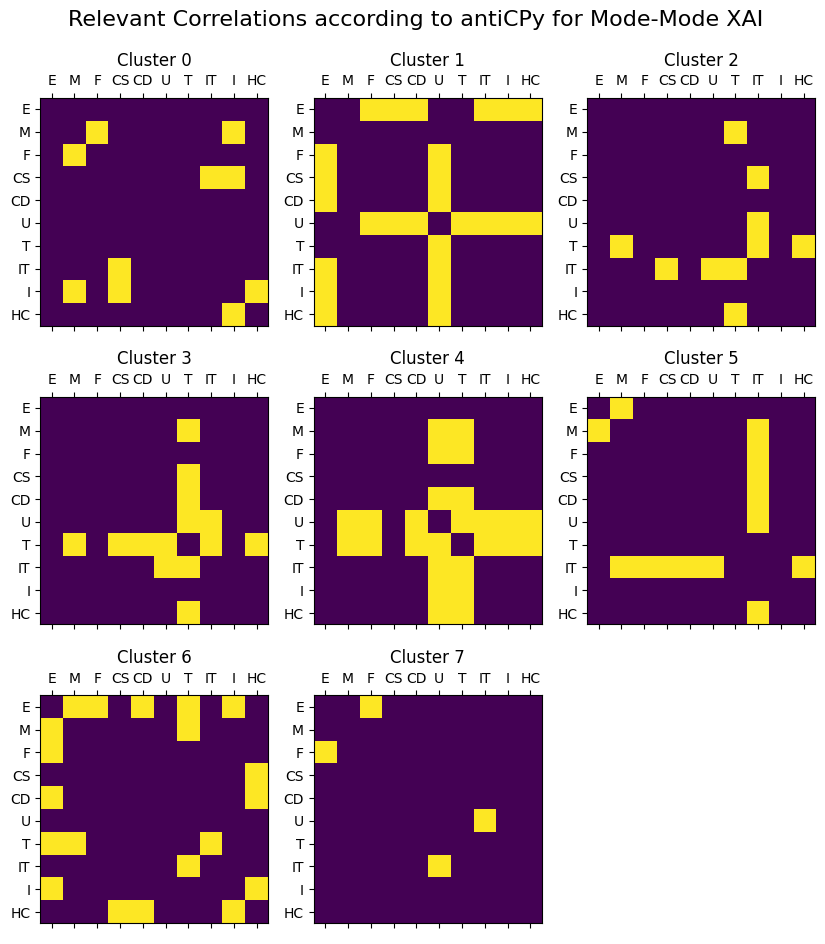

In [48]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(10, 11)
k = 0
l = 0 # row

fig.suptitle("Relevant Correlations according to antiCPy for Mode-Mode XAI", y=0.95, fontsize = 16)
for j in range(1+int(max(LabelNaiveOrdered))):
    relIndex = np.zeros(45)
    relIndex[CP_Modal_list[j][1]] = 1.
    RelMat = ReverseDiag(relIndex,
                       ZERO = True)
    axs[l,k].title.set_text("Cluster "+str(j))
    axs[l,k].matshow(RelMat)

    xaxis = np.arange(len(Names))
    axs[l,k].set_xticks(xaxis)
    axs[l,k].set_yticks(xaxis)
    axs[l,k].set_xticklabels(Names)
    axs[l,k].set_yticklabels(Names)

    k +=1
    k = k%3
    if k==0:
        l+=1

 #   plt.xlabel('Sectors')
#    plt.ylabel('Sectors')
axs[-1, -1].axis('off')
plt.savefig("RelevantCorrelations.pdf", dpi=400)
plt.show()

0.008895026028480081


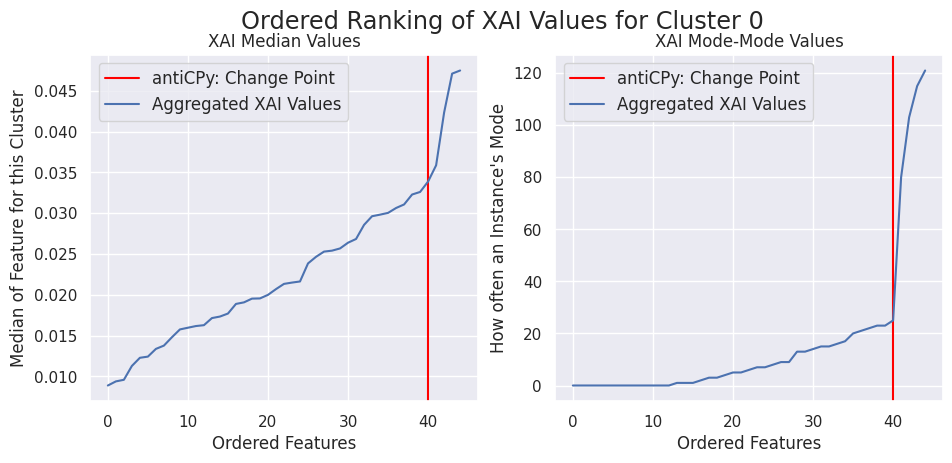

0.0029409272940940524


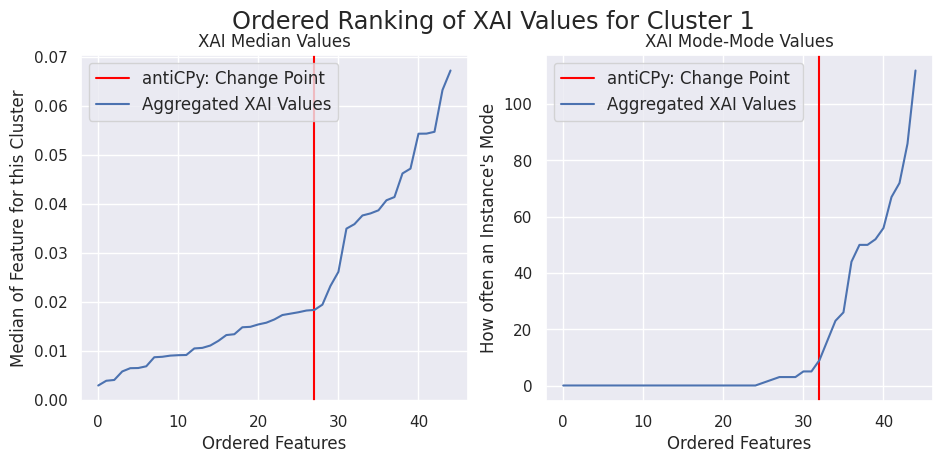

0.0068973704592516895


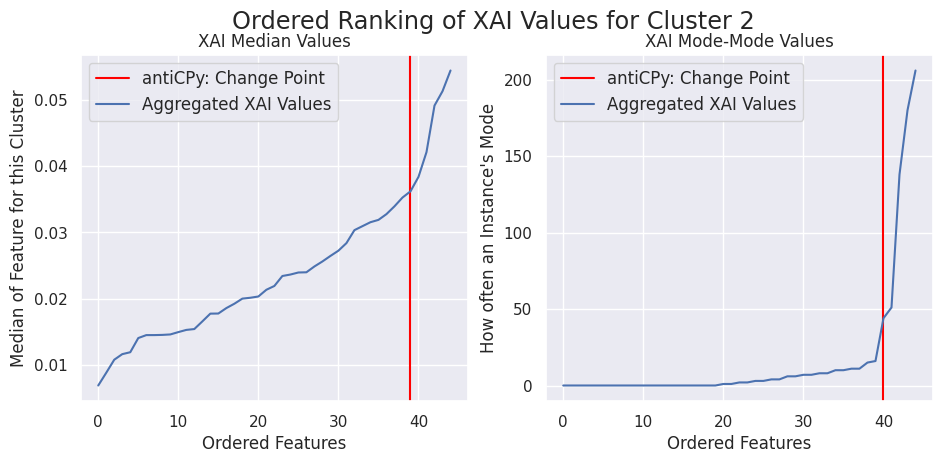

0.005535929125433043


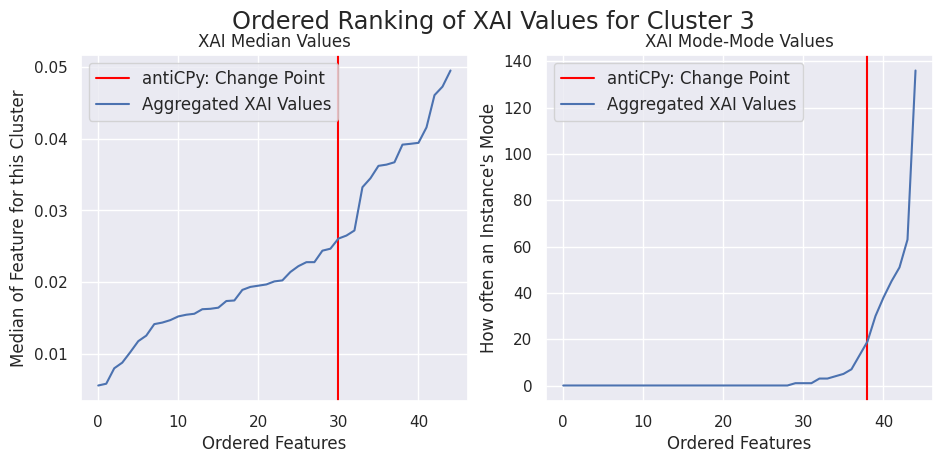

0.0026793870896212753


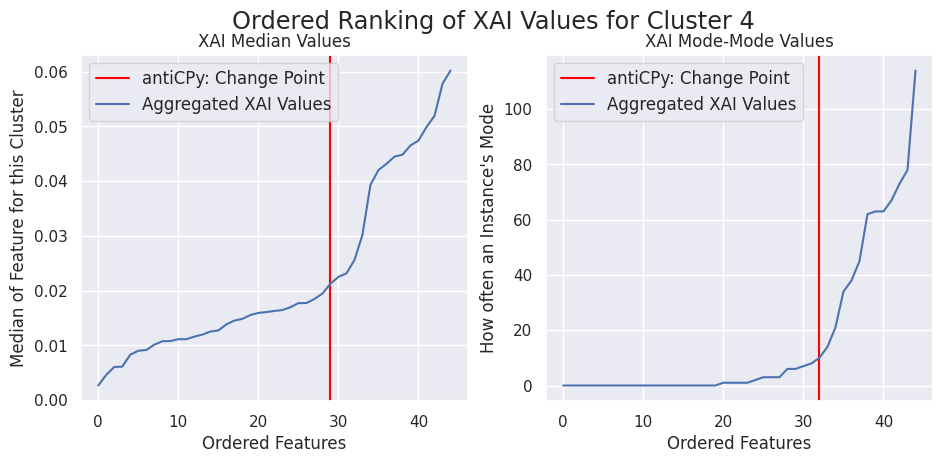

0.0024746233342728655


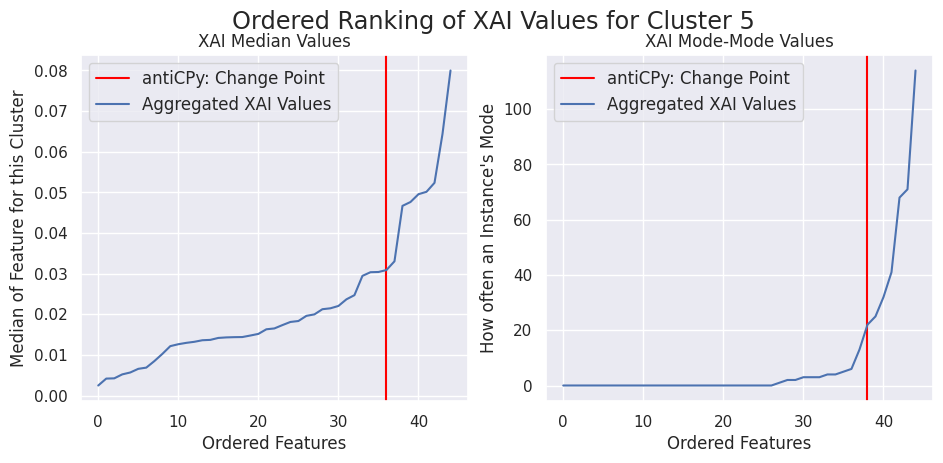

0.003326663665748834


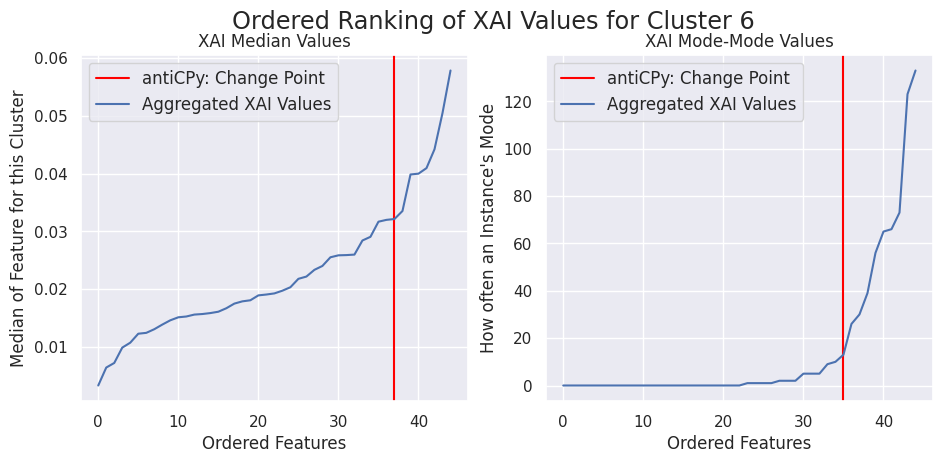

0.005520870691241187


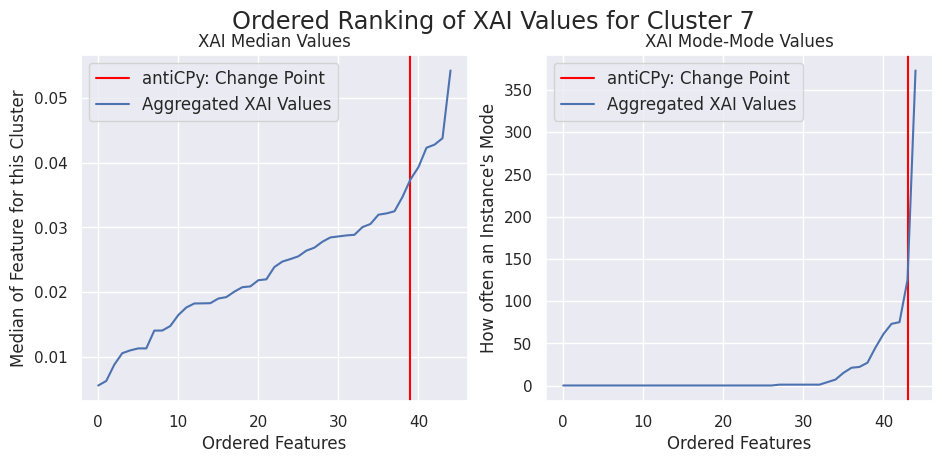

In [49]:
XAI_medians = np.empty((int(max(LabelNaiveOrdered)+1),2))
sns.set()
for j in range(1+int(max(LabelNaiveOrdered))):
    XAI_j = XAI[LabelNaiveOrdered==j,:]

    fig, ( ax2, ax3) = plt.subplots(1, 2)
    fig.set_size_inches(11, 4.5)
    fig.suptitle('Ordered Ranking of XAI Values for Cluster '+str(j),
                 fontsize = 'x-large')#,y=1.01)

    print(mode(np.median(XAI_j,0))[0][0])
    XAI_medians[j,0] = j
    XAI_medians[j,1] = int(mode(np.median(XAI_j,0))[0][0])


    Medians = np.median(XAI_j,0)
    RM = RankModes(Modes)

    ax2.set_title("XAI Median Values", fontsize = 12)
    ax2.set_ylabel("Median of Feature for this Cluster", fontsize = 12)
    ax2.set_xlabel("Ordered Features", fontsize = 12)
    ax2.axvline(len(Medians)-CP_Median_list[j][0],c="red",label="antiCPy: Change Point")
    ax2.plot(np.sort(Medians), label="Aggregated XAI Values")
    ax2.legend(fontsize=12)

    Modes = np.unique(np.argmax(XAI[LabelNaiveOrdered==j,:],1),
             return_counts=True)
    RM = RankModes(Modes)

    ax3.set_title("XAI Mode-Mode Values", fontsize = 12)
    ax3.set_xlabel("Ordered Features", fontsize = 12)
    ax3.set_ylabel("How often an Instance's Mode", fontsize = 12)
    ax3.axvline(len(RM[:,1])-CP_Modal_list[j][0],c="red",
                label="antiCPy: Change Point")
    ax3.plot(np.sort(RM[:,1]),
             label="Aggregated XAI Values")
    ax3.legend(fontsize=12)
    plt.subplots_adjust(top=0.88)
    plt.savefig("XAI Elbows Cluster "+str(j)+".pdf",dpi=600)
    plt.show()

In [51]:
import matplotlib
matplotlib.rc_file_defaults()

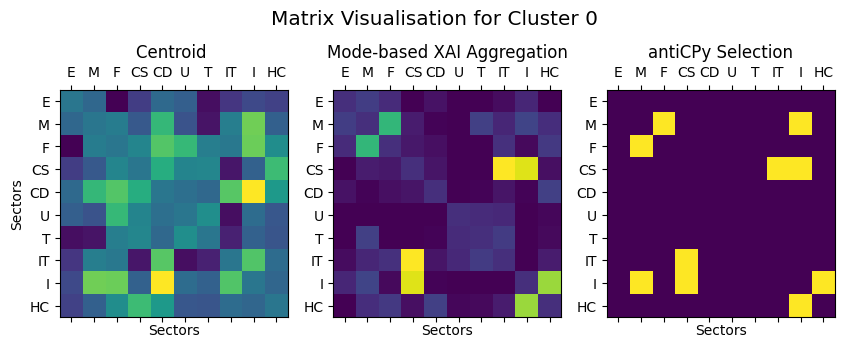

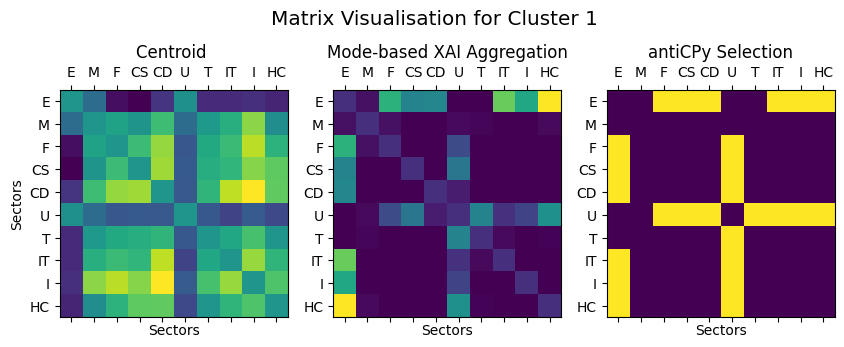

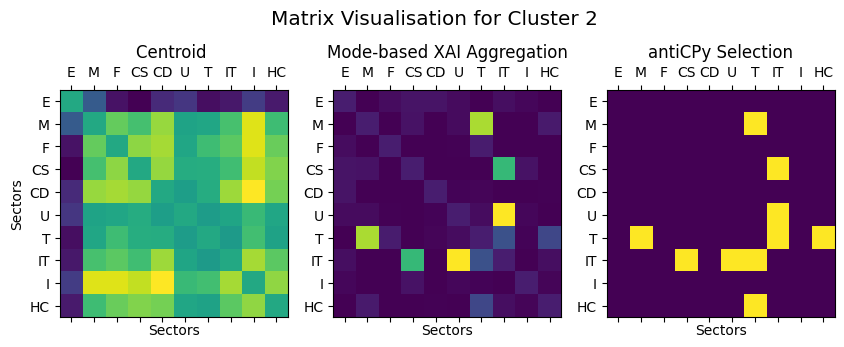

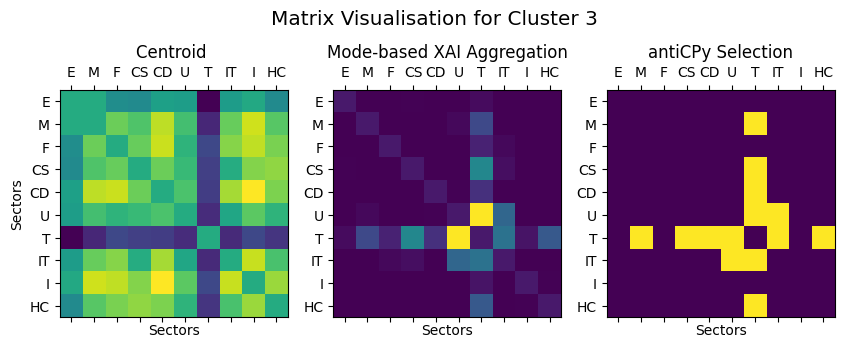

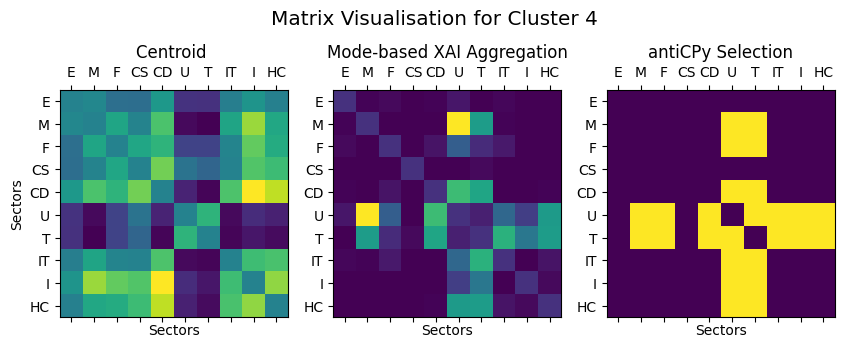

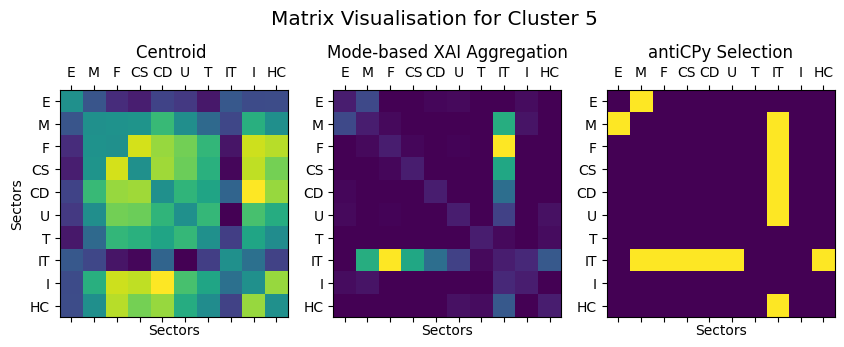

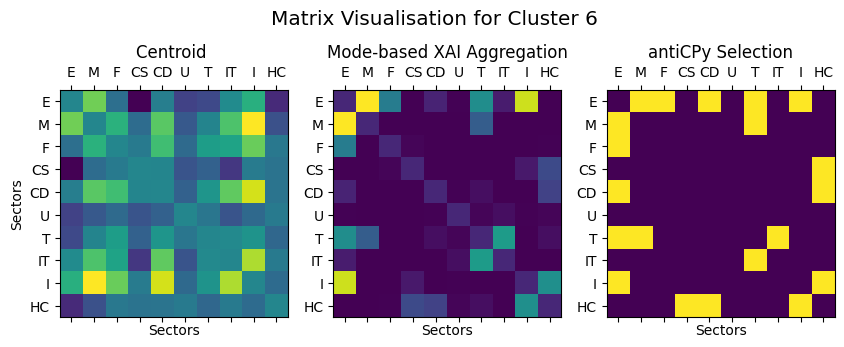

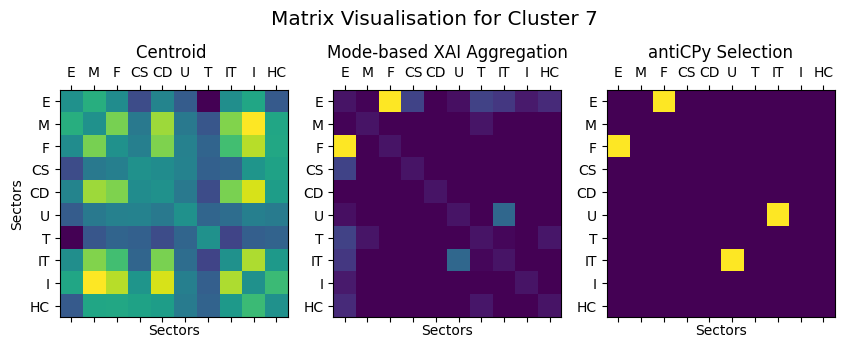

In [52]:
for j in range(1+int(max(LabelNaiveOrdered))):

    Modes = np.unique(np.argmax(XAI[LabelNaiveOrdered==j,:],1),
             return_counts=True)
    RM = RankModes(Modes)

    fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
    fig.set_size_inches(10, 4)
    fig.suptitle('Matrix Visualisation for Cluster '+str(j),
                 fontsize = 'x-large')
    ax1.matshow(ReverseDiag(CorrMatrices[LabelNaiveOrdered==j,:].mean(0),
                            MEAN = True))
    ax1.set_title("Centroid ")
    ax1.set_xticks(xaxis)
    ax1.set_yticks(xaxis)
    ax1.set_xticklabels(Names)
    ax1.set_yticklabels(Names)

    ax2.matshow(ReverseDiag(RM[:,1], MEAN=True))
    ax2.set_title("Mode-based XAI Aggregation")
    ax2.set_xticks(xaxis)
    ax2.set_yticks(xaxis)
    ax2.set_xticklabels(Names)
    ax2.set_yticklabels(Names)


    relIndex = np.zeros(45)
    relIndex[CP_Modal_list[j][1]] = 1.
    RelMat = ReverseDiag(relIndex,
                       ZERO = True)
    ax3.title.set_text("antiCPy Selection")
    ax3.matshow(RelMat)

    xaxis = np.arange(len(Names))
    ax3.set_xticks(xaxis)
    ax3.set_yticks(xaxis)
    ax3.set_xticklabels(Names)
    ax3.set_yticklabels(Names)

    ax1.set_xlabel('Sectors')
    ax1.set_ylabel('Sectors')
    ax2.set_xlabel('Sectors')
    ax3.set_xlabel('Sectors')

    plt.savefig("Centroid_vs_XAI_cluster"+ str(j)+".pdf", dpi=350, bbox_inches='tight')
    plt.show()